In [29]:
import essentia.standard as estd
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist, squareform
from collections import OrderedDict
import csv
import pandas as pd
import xml.etree.ElementTree as ET

audioInput = 0
bpm = 0
fs = 0
path_to_data_set = '../mp3/'

#### Get audio vector and inital tempo estimation

In [30]:
def get_audio_and_tempo(path):    
    loader = estd.AudioLoader(filename=path)
    downmixer = estd.MonoMixer()
    audioInput = loader()
    tempAudioInput, fs, num_channels, md5, bit_rate, codec = loader()
    audioInput = downmixer(tempAudioInput, num_channels)
    tempo_estimation_algo = estd.PercivalBpmEstimator(maxBPM=250, minBPM=40, sampleRate=int(fs))
    bpm = tempo_estimation_algo(audioInput)
    print(bpm, 'bpm, ', fs, 'Hz')
    return audioInput, bpm, fs

#### Compute spectrogram and 2-band energy

In [31]:
def compute_spectrogram(path):
    ## var init
    beat_duration = (60/bpm)*fs  # in samples
    frame_size = int(round(beat_duration/32))
    hop_size = round(frame_size/2)
    fft_size = int(np.power(2, np.ceil(np.log2(frame_size))))
    padding_size = fft_size - frame_size
    band1 = (1, 3000)
    if fs == 16000.0: # assuming fs is either going to be 16000 or 44100 and not any other value.
        band2 = (5443, 7619)
    elif fs == 44100.0:
        band2 = (15000, 21000)
    energy_threshold = 500.0    # the 1st energy_ratio value above this will be understood as first note in audio file

    ## get necessary Essentia algorithms
    window_algo = estd.Windowing(normalized=True, size = frame_size, type = 'hann', zeroPadding = padding_size)
    fft_algo = estd.FFT(size = fft_size)
    energy1_algo = estd.EnergyBand(sampleRate=fs, startCutoffFrequency=band1[0], stopCutoffFrequency=band1[1])
    energy2_algo = estd.EnergyBand(sampleRate=fs, startCutoffFrequency=band2[0], stopCutoffFrequency=band2[1])


    spectrogram = []
    db_spectrogram = []
    print('Frame Size:', frame_size)
    print('FFT Size:', fft_size)
    print('Padding length:', padding_size)

    first_note_flag = None
    for index, frame in enumerate(estd.FrameGenerator(audioInput, frameSize = frame_size, hopSize = hop_size, startFromZero = True)):
        ## spectrogram
        windowed_frame = window_algo(frame)
        mX = abs(fft_algo(windowed_frame))
        mX[mX<np.finfo(float).eps] = np.finfo(float).eps    # if zeros add epsilon to handle log
        dbX = 20 * np.log10(mX)
        spectrogram.append(np.array(mX))
        db_spectrogram.append(np.array(dbX))

        # energies and first note location
        energy1 = energy1_algo(mX)
        energy2 = energy2_algo(mX)
        energy_ratio = energy1/energy2
        if (first_note_flag == None) and (energy_ratio > energy_threshold):
            first_note_flag = index
            print("Found first note for frame with E1=", energy1, ", E2=", energy2, ", and E1/E2=", energy_ratio)
    spectrogram = np.array(spectrogram)
    db_spectrogram = np.array(db_spectrogram)
    print('Spectrogram done. Size is (axis1, axis2):', spectrogram.shape)
    return spectrogram, db_spectrogram, fft_size, hop_size, first_note_flag

#### Plot Spectrogram (for visual feedback only)

85.2272720336914 bpm,  16000.0 Hz


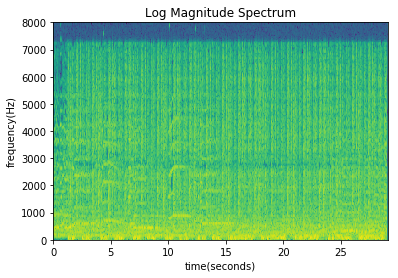

In [33]:
audioInput, bpm, fs = get_audio_and_tempo(full_path)


timeAxSec=np.arange(db_spectrogram.shape[0])*hop_size/float(fs)
freqAx_normalized=np.arange(db_spectrogram.shape[1])/float(fft_size)    #Normalized frequency axis
freqAxHz=float(fs)*freqAx_normalized

plt.pcolormesh(timeAxSec,freqAxHz,np.transpose(db_spectrogram))
plt.xlim([0,timeAxSec[-1]])
plt.ylim([0,freqAxHz[-1]])
plt.title('Log Magnitude Spectrum')
plt.ylabel('frequency(Hz)')
plt.xlabel('time(seconds)')
plt.show()

In [34]:
## time(sec) of found first note
print('First note found at time:', first_note_flag*hop_size/fs, 'seconds')

First note found at time: 0.011 seconds


Frame Size: 352
FFT Size: 512
Padding length: 160
Found first note for frame with E1= 1.7599653574507101e-06 , E2= 1.984805375609966e-10 , and E1/E2= 8867.193625520293
Spectrogram done. Size is (axis1, axis2): (2647, 257)


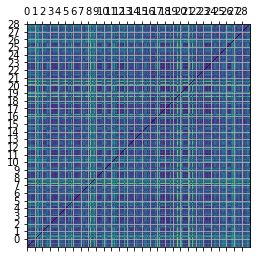

In [37]:
spectrogram, db_spectrogram, fft_size, hop_size, first_note_flag = compute_spectrogram(path)
ref_ASM = squareform(pdist(spectrogram[first_note_flag:]))

labels = list(range(int(len(audioInput)/fs)))
plt.matshow(ref_ASM[::-1])
stride = list(np.multiply(fs/hop_size, labels))
plt.xticks(stride, labels)
plt.yticks(stride, labels[::-1])
plt.grid(True)

In [12]:
bar_candidates = np.multiply(64, list(range(2, 13)))

In [13]:
def segment_diagonal(diagonal, bar_length):
    return [diagonal[i:i+bar_length] for i in range(0, len(diagonal), bar_length)]

In [14]:
def compute_similarity():
    ref_ASM = squareform(pdist(spectrogram[first_note_flag:]))
    diagonals = {}
    SCS = {}
    SIS = {}
    SM = {}
    for bar in bar_candidates:
        diagonals[bar] = {}
        numb_diagonals = int(ref_ASM.shape[0]/bar)
        for i in range(1, numb_diagonals+1):
            diagonals[bar][i] = list(np.diagonal(ref_ASM, bar*i))
            diagonals[bar][i] = segment_diagonal(diagonals[bar][i], bar)
        SCS[bar] = {}
        SIS[bar] = {}
        for diagonal in range(1, numb_diagonals+1):
            SCS[bar][diagonal] = []
            SIS[bar][diagonal] = []
            for segment in diagonals[bar][diagonal]:
                if len(segment) == bar:
                    SCS[bar][diagonal].append(math.sqrt(sum(list(np.power(segment, 2)))/len(segment)))
                elif len(segment) != bar:
                    SIS[bar][diagonal].append(math.sqrt(sum(list(np.power(segment, 2)))/len(segment)))
        SM[bar] = None
        scsi = 0
        sisi = 0
        sc = 0
        si = 0
        if len(diagonals[bar]) is 0:
            r = 0
        else: 
            r = len(diagonals[bar][1][-1])
        for diagonal in range(1, numb_diagonals+1):
            scsi += sum(SCS[bar][diagonal][:])
            sisi += SIS[bar][diagonal][0]
            sc += len(SCS[bar][diagonal][:])
            si += len(SIS[bar][diagonal][:])
        SM[bar] = (bar*scsi + r*sisi)/(bar*sc + r*si)
    return SM

In [24]:
path_to_csv = '../annotations_final.csv'
path_to_xml = '../mp3_echonest_xml'
pd_annotations = pd.read_csv(path_to_csv, '\t')

def getTrackCollection(tag='rock', num=1, minConfidence=0.8):
    collection = {}
    for i in range(pd_annotations.shape[1]):
        if pd_annotations[tag][i] == 1:
            xml_track = ET.parse(path_to_xml + '/' + pd_annotations['mp3_path'][i] + '.xml').getroot()
            for child in xml_track:
                if float(child.attrib['timeSignatureConfidence']) >= minConfidence:
                    if child.attrib['timeSignature'] not in collection:
                        collection[child.attrib['timeSignature']] = []
                    if len(collection[child.attrib['timeSignature']]) < num:
                        if float(child.attrib['timeSignatureConfidence']) >= minConfidence:
                            collection[child.attrib['timeSignature']].append({'path': pd_annotations['mp3_path'][i],
                                                                          'timeSignatureConfidence': child.attrib['timeSignatureConfidence'],
                                                                          'tempo':child.attrib['tempo']})    
    return collection

4
../mp3/c/lvx_nova-lvx_nova-01-contimune-233-262.mp3
82.4175796508789 bpm,  16000.0 Hz
Frame Size: 364
FFT Size: 512
Padding length: 148
Found first note for frame with E1= 0.09705301374197006 , E2= 1.695222636044491e-05 , and E1/E2= 5725.089535639194
Spectrogram done. Size is (axis1, axis2): (2560, 257)
11.0
is estimation equal to truth? False


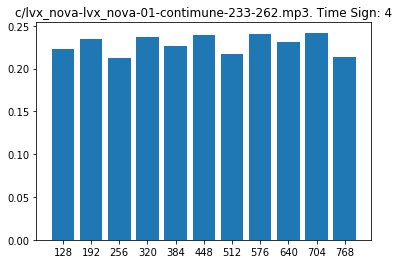

../mp3/0/rocket_city_riot-last_of_the_pleasure_seekers-01-under_the_bright_lights-30-59.mp3
98.03921508789062 bpm,  16000.0 Hz
Frame Size: 306
FFT Size: 512
Padding length: 206
Found first note for frame with E1= 0.13540951907634735 , E2= 1.831292138376739e-05 , and E1/E2= 7394.206322338861
Spectrogram done. Size is (axis1, axis2): (3045, 257)
12.0
is estimation equal to truth? False


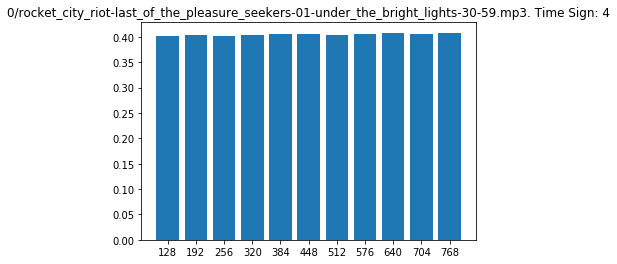

../mp3/0/rocket_city_riot-last_of_the_pleasure_seekers-01-under_the_bright_lights-146-175.mp3
94.93670654296875 bpm,  16000.0 Hz
Frame Size: 316
FFT Size: 512
Padding length: 196
Found first note for frame with E1= 0.2229491025209427 , E2= 0.0003804757434409112 , and E1/E2= 585.974549927037
Spectrogram done. Size is (axis1, axis2): (2949, 257)
10.0
is estimation equal to truth? False


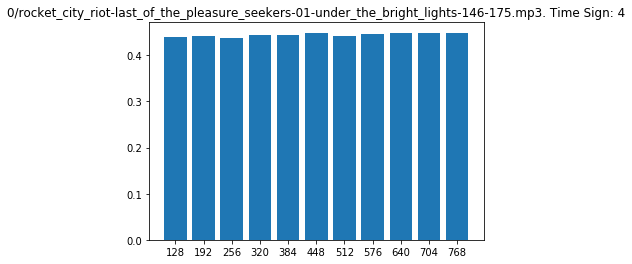

0
7
../mp3/c/mountain_mirrors-lunar_ecstasy-01-a_short_burst_of_clarity-146-175.mp3
85.2272720336914 bpm,  16000.0 Hz
Frame Size: 352
FFT Size: 512
Padding length: 160
Found first note for frame with E1= 1.7599653574507101e-06 , E2= 1.984805375609966e-10 , and E1/E2= 8867.193625520293
Spectrogram done. Size is (axis1, axis2): (2647, 257)
11.0
is estimation equal to truth? False


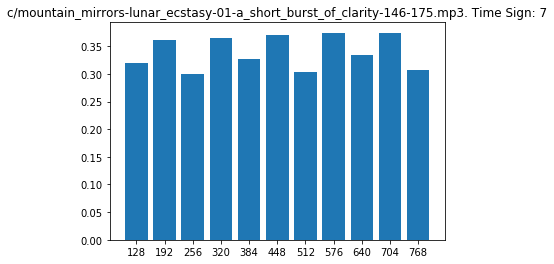

In [28]:
for timeSig, paths in getTrackCollection('rock', 3, 0.8).items():
    print(timeSig)
    if int(timeSig) == 0:
        continue
    for path in paths:
        full_path = path_to_data_set + path['path']
        print(full_path)
        audioInput, bpm, fs = get_audio_and_tempo(full_path)
        spectrogram, db_spectrogram, fft_size, hop_size, first_note_flag = compute_spectrogram(path)
        SM = compute_similarity()
        
        top_candidate = list(SM.keys())[list(SM.values()).index(max(list(SM.values())))] / 64
        print(top_candidate)
        
        print("is estimation equal to truth? " + str(timeSig == int(top_candidate)))
        
        ordered_SM = OrderedDict(sorted(SM.items()))
        plt.bar(range(len(ordered_SM)), list(ordered_SM.values()), align='center')
        xlabels = list(ordered_SM.keys())
        plt.title(path['path'] + ". Time Sign: " + timeSig)
        plt.xticks(range(len(ordered_SM)), xlabels)
        plt.show()

In [77]:
top_candidate = list(SM.keys())[list(SM.values()).index(max(list(SM.values())))] / 64
if top_candidate == 2:
    time_signature = '{}/2'.format(int(top_candidate))
elif top_candidate > 2 and top_candidate < 6:
    time_signature = '{}/4'.format(int(top_candidate))
else:
    time_signature = '{}/8'.format(int(top_candidate))
print('The estimated time signature is... ', time_signature)

The estimated time signature is...  11/8
